In [1]:
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display # to display images
import torchvision as thv
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import torch

## Q2

In [2]:
def shuffle_dataset(X, Y):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    return X[indices], Y[indices]

def subsample(dataset, num_samples, num_classes):
    X = dataset.data.numpy()

    # flatten X and change type
    X = X.reshape(X.shape[0], -1).astype(np.float32)

    Y = np.array(dataset.targets)

    # final size of each class
    class_size = int(num_samples / 10)
    indices = []

    for label in range(num_classes):
        # find indices for the given label and select the first class_size elements
        label_indices = np.argwhere(Y == label)[:class_size].flatten()
        indices.extend(label_indices)

    indices = np.array(indices)
    sampled_X = X[indices]
    sampled_Y = Y[indices]

    # normalize x
    sampled_X = sampled_X / 255.0

    return sampled_X, sampled_Y

def batch_generator(X, Y, batch_size):
    while True:
        X, Y = shuffle_dataset(X, Y)
        for i in range((X.shape[0] - batch_size) // batch_size):
            yield X[i * batch_size: i * batch_size + batch_size], Y[i * batch_size: i * batch_size + batch_size]

np.random.seed(20)

# load dataset
train = thv.datasets.MNIST('./', download=True, train=True)
val = thv.datasets.MNIST('./', download=True, train=False)

trainX, trainY = subsample(dataset=train, num_samples=10*1000, num_classes=10)
valX, valY = subsample(dataset=val, num_samples=500*10, num_classes=10)

In [3]:
def resize_images(df, old, new):
    df_temp = df
    num_samples = df_temp.shape[0]
    df_temp = df_temp.reshape((num_samples, old, old))
    downsized = np.zeros((num_samples, new, new))
    for ix in range(num_samples):
        downsized[ix] = cv2.resize(df_temp[ix], (new, new))
        _, downsized[ix] = cv2.threshold(downsized[ix]*255,127,1,cv2.THRESH_BINARY)
    downsized = downsized.reshape((num_samples, new**2))
    return downsized

In [4]:
resized_train_x = resize_images(trainX, 28, 14)
resized_val_x = resize_images(valX, 28, 14)

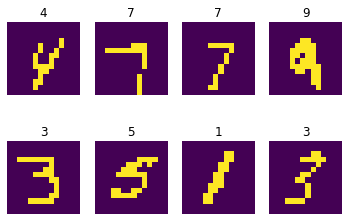

In [5]:
fig, axs = plt.subplots(2, 4)
index = np.random.randint(len(trainX), size=8)
i = 0

for r in range(2):
    for c in range(4):
        axs[r, c].imshow(resized_train_x[index[i]].reshape(14, 14))
        axs[r, c].set_title(str(trainY[index[i]]))
        axs[r, c].axis('off')
        i+=1

In [6]:
BATCH_SIZE = 32
train_dataloader = batch_generator(resized_train_x, trainY, batch_size=BATCH_SIZE)
val_dataloader = batch_generator(resized_val_x, valY, batch_size=BATCH_SIZE)

In [7]:
def KL(mu, sigma):
    contribution = 1 + sigma - mu**2 - torch.exp(sigma)
    return (torch.sum(-contribution/2))
    
def AELoss(x, mu, sigma, decoding):
    kl_loss = KL(mu, sigma)
    
    bce =  F.binary_cross_entropy(decoding, x.view(-1, 196), reduction='sum')     
    return (kl_loss + bce, kl_loss, bce)

1. Two fully-connected layers
    - first has 196 inputs and 128 outputs + tanh nonlinearity
    - second has 128 inputs and 16 outputs + no nonlinearity
1. Decoder takes as an input z, pushes it through:
    - one layer with 128 outputs + tanh nonlinearity
    - another layer with 196 output neurons + sigmoid nonlinearity

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(196, 128)
        self.fc2 = nn.Linear(128, 16)
        self.fc3 = nn.Linear(128, 16)

    def forward(self, x):
        reshaped = x.reshape(x.shape[0], -1)
        out = torch.tanh(self.fc1(reshaped))
        fc2_out = self.fc2(out)
        fc3_out = self.fc3(out)
        
        mu = (fc2_out[:, :8] + fc3_out[:, :8])/2
        logvar = (fc2_out[:, 8:] + fc3_out[:, 8:])/2
        
        std = logvar.mul(0.5).exp_()
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)  
        return z, mu, logvar
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(8, 128)
        self.fc2 = nn.Linear(128, 196)

    def forward(self, x):
        out = torch.tanh(self.fc1(x))
        out = torch.sigmoid(self.fc2(out))
        return out

In [9]:
lr = 1e-2

encoder = Encoder()
decoder = Decoder()

total_params = list(encoder.parameters())+list(decoder.parameters())
optimizer = optim.Adam(total_params, lr = lr)

In [10]:
train_error_list, train_loss_list, val_error_list, val_loss_list = [], [], [], []
bce_list, kl_list = [], []

In [38]:
for t in range(2000):
    x, y = train_dataloader.__next__()

    x = torch.Tensor(x)
    y = torch.Tensor(y).long()

    optimizer.zero_grad()

    z, mu, logvar = encoder(x)
    
    decoding = decoder(z)
            
    total_loss, kl, bce = AELoss(x, mu, logvar, decoding)
    total_loss.backward()

    optimizer.step()

    train_loss_list.append(total_loss.item()/BATCH_SIZE)
    kl_list.append(kl.item()/BATCH_SIZE)
    bce_list.append(bce.item()/BATCH_SIZE)
    print(t, kl_list[-1], bce_list[-1], train_loss_list[-1])

0 9.553079605102539 28.63153648376465 38.18461608886719
1 9.030292510986328 28.87540626525879 37.90570068359375
2 8.380939483642578 27.42597198486328 35.80691146850586
3 8.808622360229492 28.533889770507812 37.34251403808594
4 8.929679870605469 26.722923278808594 35.65260314941406
5 9.293350219726562 26.356855392456055 35.65020751953125
6 9.374314308166504 29.642681121826172 39.01699447631836
7 8.92158031463623 23.668596267700195 32.59017562866211
8 9.239920616149902 25.68515396118164 34.92507553100586
9 8.723113059997559 27.420249938964844 36.14336395263672
10 8.638965606689453 23.613357543945312 32.252323150634766
11 9.088433265686035 28.98977279663086 38.07820510864258
12 8.92081069946289 27.100414276123047 36.02122497558594
13 9.086325645446777 24.004558563232422 33.090885162353516
14 8.966483116149902 26.92670249938965 35.893184661865234
15 9.021669387817383 27.975202560424805 36.99687194824219
16 9.075357437133789 27.549787521362305 36.625144958496094
17 8.47313404083252 25.31821

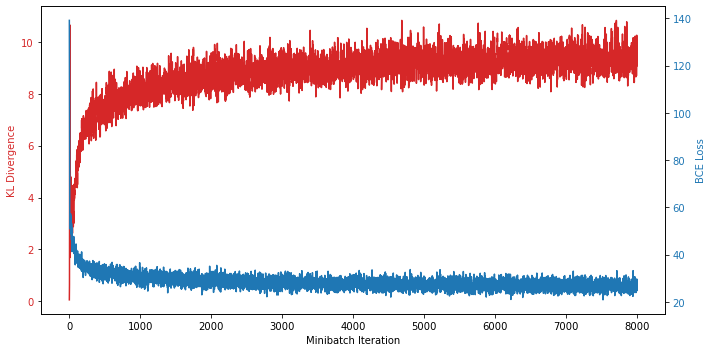

In [45]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:red'
ax1.set_xlabel('Minibatch Iteration')
ax1.set_ylabel("KL Divergence", color=color)
ax1.plot(np.arange(len(kl_list)), kl_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel("BCE Loss", color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(len(bce_list)), bce_list, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

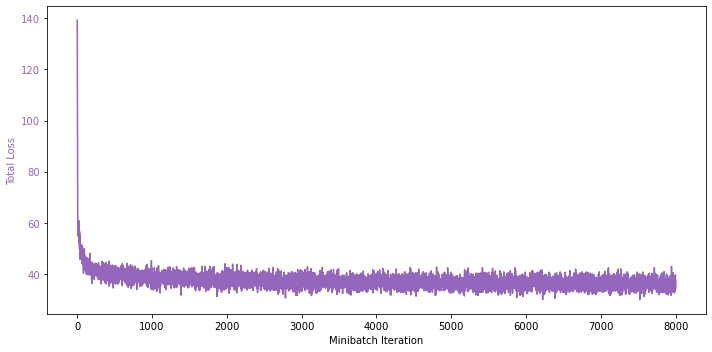

In [52]:
fig, ax1 = plt.subplots(figsize=(10, 5))

color = 'tab:purple'
ax1.set_xlabel('Minibatch Iteration')
ax1.set_ylabel("Total Loss", color=color)
ax1.plot(train_loss_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

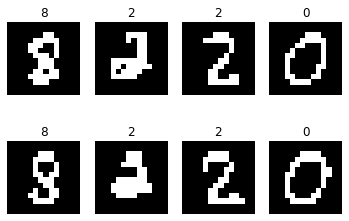

In [57]:
num_samples = 4
fig, axs = plt.subplots(2, num_samples)

index = np.random.randint(len(resized_val_x), size=8)
i = 0

for c in range(num_samples):
    x = resized_val_x[index[i]]
    axs[0, c].imshow(x.reshape(14, 14), cmap=plt.cm.gray)
    axs[0, c].set_title(str(valY[index[i]]))
    axs[0, c].axis('off')
    
    x = torch.Tensor(x).unsqueeze(0)
    z, mu, sigma = encoder(x)
    decoding = decoder(z)
    
    decoding = decoding.reshape((14, 14)).detach().numpy()
    _, decoding = cv2.threshold(decoding*255,127,255,cv2.THRESH_BINARY)

    axs[1, c].imshow(decoding, cmap=plt.cm.gray)
    axs[1, c].set_title(str(valY[index[i]]))
    axs[1, c].axis('off')
    i+=1
plt.show()    